In [39]:
import numpy as np
import pandas as pd
from skimage import io,util,color
import matplotlib.pyplot as plt
import random
from skimage.transform import rescale, resize
import os

In [3]:
#Haar-like
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

In [4]:
#HOG
from skimage.feature import hog

In [5]:
#adaboost
from sklearn.ensemble import AdaBoostClassifier

In [6]:
#Calculate le overlap
def IoU(a,b):
    a_y = a[1]+a[3]
    a_x = a[2]+a[4]
    b_y = b[1]+b[3]
    b_x = b[2]+b[4]
    overlapY = (b_y-b[1])+(a_y-a[1]) - ( max(a_y,b_y) - min(a[1],b[1]) )
    overlapX = (b_x-b[2])+(a_x-a[2]) - ( max(a_x,b_x) - min(a[2],b[2]) )

    if overlapY <= 0 or overlapX <= 0:
        I = 0
    else:
        I = overlapX*overlapY
    U = a[3]*a[4]+b[3]*b[4]-I
    return I/U

In [8]:
def generate_neg(im, size_h,size_l, nb = None):
    x,y = im.shape
    if nb == None: nb = 2000
    neg = np.empty((nb,size_h,size_l))
    for k in range(nb):
        i = random.randint(1,x-size_h)-1
        j = random.randint(1,y-size_l)-1
        neg[k] = im[i:i+size_h,j:j+size_l]
    return neg

In [127]:
#HOG 
def hog_feature(train,size_h, size_l, ori= None,cell=None,block=None):
    if ori == None: ori = 9 
    if cell == None: cell = 9 
    if block == None: block = 3
    #for 1 vector(image)
    size = ori*block*block*((size_h-cell*(block-1))//cell)*((size_l-cell*(block-1))//cell)
    if train.ndim == 1:
        p = hog(train, orientations=ori, pixels_per_cell=(cell, cell),
                    cells_per_block=(block, block), block_norm='L2-Hys', 
                    visualize=False, transform_sqrt=False, 
                    feature_vector=True, multichannel=None)
    #for n vectors(images)
    else:
        p = np.zeros((train.shape[0],size))
        for j in range(train.shape[0]):
            p[j] = hog(train[j], orientations=ori, pixels_per_cell=(cell, cell),
                    cells_per_block=(block, block), block_norm='L2-Hys', 
                    visualize=False, transform_sqrt=False, 
                    feature_vector=True, multichannel=None)
    return p

In [10]:
def haar_feature(pos,neg):
    pass

In [10]:
def load_im():
    test = [np.array(util.img_as_float(color.rgb2gray(io.imread('test/%04d.jpg'%(i+1))))) for i in range(500)]
    train = [np.array(util.img_as_float(color.rgb2gray(io.imread('train/%04d.jpg'%(i+1))))) for i in range(1000)]
    return test,train

In [163]:
def slide_window(image,size_h, size_l,step_size,model,label, nb_ima, threshold=None):
    if threshold == None: threshold = 0.5
    x,y = image.shape
    win = np.zeros((0,6))
  #  fp = np.zeros((0,size_h,size_l))
    ind = 0
    #slide window
    #for every window, get a hog and the overlap with true face
    for i in range(0,x-size_h,step_size):
        for j in range(0,y-size_l,step_size):
            window = image[i:i+size_h,j:j+size_l]
            
            #predict with hog
            h = hog(window, orientations=ori, pixels_per_cell=(cell, cell),
                    cells_per_block=(block, block), block_norm='L2-Hys', 
                    visualize=False, transform_sqrt=False, 
                    feature_vector=True, multichannel=None)

            s = model.decision_function(h.reshape(1,-1))[0]
            
            #if overlap with face < 0.5 and detected as a face, add it into faux positives
            
            if s > 0.2: #0.4 = 2 * (p(y=1)-p(y=0))  so p>0.6we suppose it is a face
                # calculate overlap with true face
                overlap = 0
                for k in range(label.shape[0]):
                    olk = IoU(label[k],[0,i,j,size_h,size_l])
                    if olk > overlap:
                            overlap = olk

                if overlap < threshold: 
                    m = win.shape[0]
                    w = np.array([label[0,0],i,j,size_h,size_l,s]).reshape(1,-1)
                    win = np.concatenate((win,w),axis = 0)
                    #if there exists similar windows in faux positives, choose the one with higher possibility
                    id = []
                    for l in range(m):             
                        o = IoU(win[l,0:5],win[m,0:5])
                        if o > 0.5 and s > win[l,5]:
                            id.append(l)
                    if len(id) != 0:
                        win = np.delete(w,id,axis=0)
            ind += 1
            
#     for m in win:
#         i,j,k,l = m[1:5]
#         im = image[i:i+size_h,j:j+size_l]
#         fp = np.concatenate(fp,im,axis=0)
    
    nb_ima += 1
    print("{i}th fp size: {s}".format(i = nb_ima,s=win.shape))
    return win,nb_ima

In [164]:
def NMS(labels):
    mask = np.ones((labels.shape[0]))
    for i in range(labels.shape[0]-1):
        for j in range(i+1,labels.shape[0]):
            inter = IoU(labels[i],labels[j])
            if inter > 0.5:
                if labels[i,5] > labels[i,5]:
                    mask[j] = 0
                else:
                    mask[i] = 0
    return labels[mask.astype(bool)]

In [141]:
np.diag(np.array((1,0.3,0.3,1,1,1)))

array([[1, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 3, 0],
       [0, 0, 0, 4]])

In [149]:
w = np.array([[1,2,3,4,5,6],[2,7,8,9,0,6],[3,4,3,2,1,6],[4,4,3,2,1,6],[5,4,3,2,1,6],[6,4,3,2,1,6]])
t = np.diag(np.array((1,0.3,0.3,1,1,1)))
c = np.array((1,1,0,0,1,1))
w[c.astype(bool)]

array([[1, 2, 3, 4, 5, 6],
       [2, 7, 8, 9, 0, 6],
       [5, 4, 3, 2, 1, 6],
       [6, 4, 3, 2, 1, 6]])

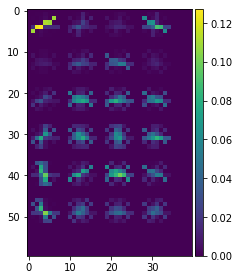

In [273]:
a = hog(pos[346], orientations=9, pixels_per_cell=(9, 9),
                    cells_per_block=(3, 3), block_norm='L2-Hys', 
                    visualize=True, transform_sqrt=False, 
                    feature_vector=True, multichannel=None)
io.imshow(a[1])

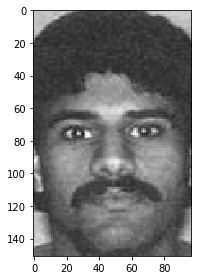

In [240]:
im_indexm,im,jm,km,lm = labels[346]
io.imshow(train[im_indexm-1][im:im+km,jm:jm+lm])

In [13]:
#get the data
test,train = load_im()

#get labels
labels = np.loadtxt('label_train.txt',dtype = int) # k, i, j, h, l, s
size_h = 60
size_l = 40

im_index,i,j,k,l = labels[0]

#generate positive
nb_pos = labels.shape[0]
pos = np.zeros((nb_pos,size_h,size_l))
for m in range(nb_pos):
    im_indexm,im,jm,km,lm = labels[m]
    pos[m] = resize(train[im_indexm-1][im:im+km,jm:jm+lm],(size_h,size_l),anti_aliasing=True)
# pos0 = resize(train[im_index-1][i:i+k,j:j+l],(size,size))

#generate neatives
nb_neg = 2000
neg = generate_neg(train[im_index-1],size_h,size_l,nb_neg)
train_1 = np.concatenate([pos,neg],axis=0)
nb_train_1 = nb_neg + nb_pos
Y_train_1 = np.concatenate([np.ones(nb_pos),np.zeros(nb_neg)],axis=0)

#feature extraction
ori = 9 
cell = 9 
block = 3
X_train_1 = hog_feature(train_1,size_h,size_l,ori,cell,block)

##use of CV

#first train

#Adaboost
#ada = train_adaboost(X_train_1,Y_train_1)
ada = AdaBoostClassifier(n_estimators=50)
ada.fit(X_train_1 , Y_train_1)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [178]:
ind,i,j,k,l = labels[0,:5]
train[ind][i:i+k][j:j+l].shape

(62, 449)

In [181]:
fp_labels.astype(int)[0,:5]

array([ 0, 33, 52, 60, 40])

In [203]:
fp = np.zeros((0,size_h,size_l))
fp_labels = np.zeros((0,6))
#slides windows
#mean h/l  = 1.5195370402700235
#biggist face:407 275 smallest window:23 13
#so the image size vary from 60/407 (0.14742/0.15) to 40/13 (3)
for i in range(2):
    label = labels[labels[:,0]==(i+1)]
    imag = []
    fp_labels_image = np.zeros((0,6))
    print("the {}th image:".format(i+1))
    #resize image
    im_x,im_y = train[i].shape
    nb_ima = 0
    for j in np.append(np.arange(0.75,0,-0.15),np.array([1,1.5,3])):
        if im_x*j < size_h or im_y*j < size_l:
            break
        else:
            imag = rescale(train[i],j,anti_aliasing=True)
            lab = (label*j).astype(int)
            win,nb_ima = slide_window(imag,size_h, size_l,8,ada,lab,nb_ima)
            if win.shape[0] != 0:
                trans = np.diag(np.array((1,1/j,1/j,1/j,1/j,1)))
                win_trans = (np.dot(win,trans)).astype(int)
                fp_labels_image = np.concatenate((fp_labels_image,win_trans),axis = 0).astype(int)
                #12:34
                #13：44 42 7
    if fp_labels_image.shape[0] != 0:
        fp_labels = np.concatenate((fp_labels,NMS(fp_labels_image) ),axis = 0)

the 1th image:
1th fp size: (1, 6)
2th fp size: (0, 6)
3th fp size: (0, 6)
4th fp size: (0, 6)
5th fp size: (0, 6)
6th fp size: (0, 6)
7th fp size: (2, 6)
8th fp size: (17, 6)
the 2th image:
1th fp size: (1, 6)
2th fp size: (0, 6)
3th fp size: (0, 6)
4th fp size: (0, 6)


In [217]:

a = []
for f in fp_labels.astype(int):
    ind,i,j,k,l = f[:5]
    b = train[ind][i:i+k,j:j+l]
    a.append(b)
e = []
for d in a:
    c = hog(resize(d,(60,40)), orientations=ori, pixels_per_cell=(cell, cell),
                    cells_per_block=(block, block), block_norm='L2-Hys', 
                    visualize=False, transform_sqrt=False, 
                    feature_vector=True, multichannel=None)
    if ada.predict(c.reshape(1,-1))[0] < 1:
        e.append(d)
        

18

407 275
21 13
1.5195370402700235
0.25
0.0132398753894081


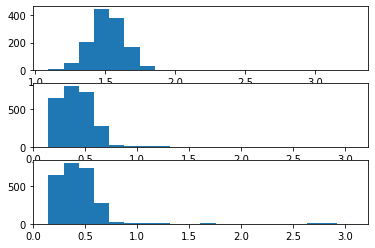

In [289]:
a=b=0
e=f=260
p = 100
a1=b1=[]
q = []
p1 = 0
for i in labels:
    c = i[3]
    d = i[4]
    p1 += c/d
    if c > a:
        a = c
    if d > b:
        b = d
    if c < e:
        e = c
    if d < f:
        f = d
    q.append(c/d)
    a1.append(60/c)
    b1.append(40/d)
print(a,b)
print(e,f)
print(p1/len(labels))

plt.subplot(311)
plt.hist(q,bins=20)

plt.subplot(312)
plt.hist(a1,bins=20)

plt.subplot(313)
plt.hist(b1,bins=20)
print(np.sum(np.array(q)>1.6)/len(q)) #0.25   75%proportion
print(np.sum(np.array(q)>1.8)/len(q)) #0.0132398753894081    plus de 98%proportion
#donc choisir 1.8

In [91]:
a = np.array(pyramid_gaussian(train[i], max_layer=-1, downscale=2, sigma=None, order=1, mode='reflect', cval=0, multichannel=False))

311 450
n_rows, n_cols:  156 225
n_rows, n_cols:  78 113
n_rows, n_cols:  39 57
n_rows, n_cols:  20 29
n_rows, n_cols:  10 15
n_rows, n_cols:  5 8
n_rows, n_cols:  3 4
n_rows, n_cols:  2 2
n_rows, n_cols:  1 1


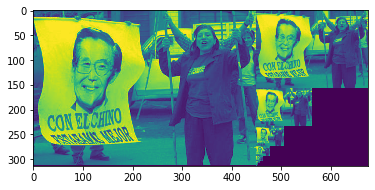

In [187]:
rows, cols = train[4].shape
print(rows,cols)
pyramid = list(pyramid_gaussian(train[4], downscale=2, multichannel=False))

composite_image = np.zeros((rows+3, cols+cols//2+1 ), dtype=np.double)

composite_image[:rows, :cols] = pyramid[0]

i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols = p.shape[:2]
    print("n_rows, n_cols: ",n_rows, n_cols)
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

fig, ax = plt.subplots()
ax.imshow(composite_image)
plt.show()

In [94]:
del test
del train
del labels
del neg
del pos
del X_train_1
del train_1